In [3]:
using LinearAlgebra
using Unitful
using UnitfulAstro
using OrdinaryDiffEq
using Plots
#using FLoops
#using Distributed
#using DisplayAs
#include("./GalaxyCollisionFunctions.jl")
#addprocs(4)
theme(:juno)
using Random

In [49]:
const G = 4.3009E-3 *1u"pc *(km/s)^2 /Msun"

function Spherical2Cartesian(r,ϕ,θ)
    x = r * cos(ϕ)* sin(θ)
    y = r*sin(ϕ)*sin(θ)
    z = r*cos(θ)
return [x,y,z]
end


function format_parameters(galaxy_args)
    #I didn't have this at first, but this makes all galaxies have an uniform format. Not too crazy
    return Dict(
        "mass" => galaxy_args[1]*1u"Msun",
        "DiskRadius"     => galaxy_args[2]*1u"kpc",
        "BulgeRadius" => galaxy_args[3]*1u"kpc",
        "center_pos" => galaxy_args[4].*1u"kpc",
        "center_vel" => galaxy_args[5].*1u"km/s",
        "normal"     => galaxy_args[6],
        "NₛDisk"    => galaxy_args[7],
        "NₛBulge"    => galaxy_args[8],
        "softening"  => galaxy_args[9]
    )
end

function init_disk!(galaxy,dT=1E-4u"Myr")
    #=
    This function takes a 'galaxy' as an argument, which is an array of 8 arguments=>
        [mass,DiskRadius,center_pos,center_vel,normal,N_rings,N_stars,softening]
    And outputs the star positions, velocities and the velocity scale.
    =#
#--------------------------------------------------------------------------Rotations=------------------------------------------------------------------------------------
    if norm(galaxy["normal"]) == 0 
        Rotation = I
    else 
        cosθ = normalize(galaxy["normal"])[3]
        sinθ = √(1-cosθ^2)
        u = [0,0,1] × normalize(galaxy["normal"])
        if norm(u) == 0 
            Rotation = I
        else 
         u = normalize(u)

        Rotation = [
            u[1]*u[1]*(1-cosθ)+cosθ u[1]*u[2]*(1-cosθ)-u[2]*sinθ u[1]*u[3]*(1-cosθ)+u[1]*sinθ;

            u[2]*u[1]*(1-cosθ)+u[3]*sinθ u[2]*u[2]*(1-cosθ)+cosθ u[2]*u[3]*(1-cosθ)-u[1]*sinθ;

            u[3]*u[1]*(1-cosθ)+u[2]*sinθ u[3]*u[1]*(1-cosθ)+u[1]*sinθ u[3]*u[3]*(1-cosθ)+cosθ
            ]
        end
    end
#-----------------------------------------------------------------------------------------------------------------------------------
    galaxy["star_pos"] = []
    galaxy["star_vel"] = []
#----------------------------------------------------------------------Making the Disk--------------------------------------------------------------------------------------------
    Rminimum = galaxy["softening"] * galaxy["DiskRadius"]
    if galaxy["NₛDisk"] == 0
    else
    Rdisk = (-log.(rand(galaxy["NₛDisk"]))*galaxy["DiskRadius"] .+Rminimum)*1u"1/kpc" #This (by inverse tansform sampling) gives us a negative exponential distribution on the masses. Basing myself on https://arxiv.org/pdf/1608.08350.pdf for this model
    ϕdisk = 2π *rand(galaxy["NₛDisk"])
    # Positions 
    vecᵣ = (Rotation * ([Rdisk.*cos.(ϕdisk),Rdisk.*sin.(ϕdisk),zeros(galaxy["NₛDisk"])]))
    x = ustrip.(u"m",galaxy["center_pos"][1].+vecᵣ[1]*1u"kpc")#here, we strip our units into our 'integrating' unitlessness because units don't really play nice in arrays of arrays
    y = ustrip.(u"m",galaxy["center_pos"][2].+vecᵣ[2]*1u"kpc")
    z = ustrip.(u"m",galaxy["center_pos"][3].+vecᵣ[3]*1u"kpc")

    # Velocities
    vecᵥ = []
    for j ∈ 1:galaxy["NₛDisk"]
        push!(vecᵥ,ustrip.(u"m/s",√(G *galaxy["mass"]/(Rdisk[j]*1u"kpc"))) * normalize(reduce(vcat,transpose(vecᵣ))[:,j] × galaxy["normal"])#= *(2*(rand()>0.5)-1)=#) 
    end
    Tₛ = 2π * uconvert.(u"s",sqrt.((Rdisk*1u"kpc").^3/(G *galaxy["mass"])))
    Δϕ = 2π *uconvert(u"s",dT)./Tₛ 
    vecᵥ = (Rotation* [(Rdisk/(uconvert(u"s",dT)*1u"1/s")).*(cos.(ϕdisk)-cos.(ϕdisk-Δϕ)),Rdisk/(uconvert(u"s",dT)*1u"1/s").*(sin.(ϕdisk)-sin.(ϕdisk-Δϕ)),zeros(galaxy["NₛDisk"])])*1u"kpc/s"
  #=   v₁ = ustrip.(u"m/s",galaxy["center_vel"][1]).+reduce(vcat,transpose(vecᵥ))[:,1]
    v₂ = ustrip.(u"m/s",galaxy["center_vel"][2]).+reduce(vcat,transpose(vecᵥ))[:,2]
    v₃ = ustrip.(u"m/s",galaxy["center_vel"][3]).+reduce(vcat,transpose(vecᵥ))[:,3] =#
    v₁ = ustrip.(u"m/s",galaxy["center_vel"][1].+vecᵥ[1])
    v₂ = ustrip.(u"m/s",galaxy["center_vel"][2].+vecᵥ[2])
    v₃ =ustrip.(u"m/s",galaxy["center_vel"][3].+vecᵥ[3])
    for j ∈ 1:galaxy["NₛDisk"]
        push!(galaxy["star_pos"],[x[j],y[j],z[j]])
        push!(galaxy["star_vel"],[v₁[j],v₂[j],v₃[j]])
    end
end
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------Making Bulge-----------------------------------------------------------------------------------------
    Rminimum = galaxy["softening"] * galaxy["BulgeRadius"]
    Rbulge = (-log.(rand(galaxy["NₛBulge"]))*galaxy["BulgeRadius"] .+Rminimum) #This (by inverse tansform sampling) gives us a negative exponential distribution on the masses. Basing myself on https://arxiv.org/pdf/1608.08350.pdf for this model
    ϕbulge = 2π *rand(galaxy["NₛBulge"])
    θbulge = π *rand(galaxy["NₛBulge"])
    vecᵣbulge = Spherical2Cartesian.(ustrip.(u"m",Rbulge),ϕbulge,θbulge)
    Xbulge = ustrip(u"m",galaxy["center_pos"][1]).+reduce(vcat,transpose(vecᵣbulge))[:,1]
    Ybulge = ustrip(u"m",galaxy["center_pos"][2]).+reduce(vcat,transpose(vecᵣbulge))[:,2]
    Zbulge = ustrip(u"m",galaxy["center_pos"][3]).+reduce(vcat,transpose(vecᵣbulge))[:,3]
    Vbulge = []
    for j ∈ 1:galaxy["NₛBulge"]
        push!(Vbulge,ustrip.(u"m/s",sqrt(G*Target["mass"]/(norm(vecᵣbulge[1]) *1u"kpc" *ustrip(u"kpc",1u"m"))))*normalize(vecᵣbulge[j] × rand(3)))
    end
    v₁bulge = ustrip(u"m/s",galaxy["center_vel"][1]).+reduce(vcat,transpose(Vbulge))[:,1]
    v₂bulge = ustrip(u"m/s",galaxy["center_vel"][2]).+reduce(vcat,transpose(Vbulge))[:,2]
    v₃bulge = ustrip(u"m/s",galaxy["center_vel"][3]).+reduce(vcat,transpose(Vbulge))[:,3]
    for j ∈ 1:galaxy["NₛBulge"]
        push!(galaxy["star_pos"],[Xbulge[j],Ybulge[j],Zbulge[j]])
        push!(galaxy["star_vel"],[v₁bulge[j],v₂bulge[j],v₃bulge[j]])
    end
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
end

function evolve_disk(galaxy,dT=1e-4u"yr",N_steps=100000,frames=500)
    divs = trunc(Int64,N_steps/frames)
    #Integration stuff
    dT=ustrip(u"s",dT)
    rₘ=ustrip(u"m",galaxy["softening"]*galaxy["BulgeRadius"])
    Nₛ=galaxy["NₛDisk"]+galaxy["NₛBulge"]
    
    #Galaxy stuff
    M = galaxy["mass"]
    X,Y,Z = ustrip.(u"m",galaxy["center_pos"])
    Vx,Vy,Vz = ustrip.(u"m/s",galaxy["center_vel"])

    #star stuff
    x=reduce(vcat,transpose(galaxy["star_pos"]))[:,1]
    y=reduce(vcat,transpose(galaxy["star_pos"]))[:,2]
    z=reduce(vcat,transpose(galaxy["star_pos"]))[:,3]
    vx=reduce(vcat,transpose(galaxy["star_vel"]))[:,1]
    vy=reduce(vcat,transpose(galaxy["star_vel"]))[:,2]
    vz=reduce(vcat,transpose(galaxy["star_vel"]))[:,3]
    T=0
    snapshot = zeros(frames,Nₛ+1,3)
    time = zeros(frames)
        for i ∈ 1:frames
            for j ∈ 1:Nₛ
                snapshot[i,j,:] =[x[j],y[j],z[j]] * ustrip(u"kpc",1u"m") 
            end
            snapshot[i,Nₛ+1,:] = [X,Y,Z] * ustrip(u"kpc",1u"m") 
            time[i]=T
# This used to be integrated with Julia's native libraries, but I structured it in such a way in which it would be horrible. I here pay for my sins by implementing a leapfrog.
            for j ∈ 1:divs
                r = max.(sqrt.((x.-X).^2 + (y.-Y).^2 + (z.-Z).^2),rₘ)
                vx += -ustrip(u"m^3*s^-2",G*M)*((x.-X)./r.^3) *dT
                vy += -ustrip(u"m^3*s^-2",G*M)*((y.-Y)./r.^3) *dT
                vz += -ustrip(u"m^3*s^-2",G*M)*((z.-Y)./r.^3) *dT
                x += vx*dT
                y += vy*dT
                z += vz*dT
                Vx += 0
                Vy += 0
                Vz += 0
                X += Vx*dT
                Y += Vy*dT
                Z += Vz*dT
                T += dT
            end
        end
    return snapshot,time 
end

function gif_galaxy(data,time,NₛDisk,NₛBulge,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[1:1,:,1]),maximum(data[1:1,:,1])]
        ylimit = [minimum(data[1:1,:,2]),maximum(data[1:1,:,2])]
        zlimit = [minimum(data[1:1,:,3]),maximum(data[1:1,:,3])]
    end
    @gif for i ∈ 1:length(time)
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:NₛDisk+NₛBulge
            j< NₛDisk ? colour=:red : colour=:blue
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=colour,legends=false,markersize=0.5#= ,camera=(0,90) =#,camera=(i,45))
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,NₛDisk+NₛBulge+1,1],data[i:i,NₛDisk+NₛBulge+1,2],data[i:i,NₛDisk+NₛBulge+1,3], color=:black,legends=false)
    end 
end

function print_galaxy(data,time,NₛDisk,NₛBulge,i=1,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[1:1,:,1]),maximum(data[1:1,:,1])]
        ylimit = [minimum(data[1:1,:,2]),maximum(data[1:1,:,2])]
        zlimit = [minimum(data[1:1,:,3]),maximum(data[1:1,:,3])]
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:NₛDisk+NₛBulge
            j< NₛDisk ? colour=:red : colour=:blue
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=colour,legends=false,markersize=0.8#=, camera=(0,90) =#)
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,NₛDisk+NₛBulge+1,1],data[i:i,NₛDisk+NₛBulge+1,2],data[i:i,NₛDisk+NₛBulge+1,3], color=:black,legends=false,markersize=1.5)
    end

end

function gif_two_galaxies(data,time,N₁,N₂,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[1:5,:,1]),maximum(data[1:5,:,1])]
        ylimit = [minimum(data[1:5,:,2]),maximum(data[1:5,:,2])]
        zlimit = [minimum(data[1:5,:,3]),maximum(data[1:40,:,3])]
    end
    @gif for i ∈ 1:length(time)
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:N₁
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=:red,legends=false,markersize=1)
        end
        for j ∈ 1:N₂
            scatter3d!(data[i:i,N₁+j,1],data[i:i,N₁+j,2],data[i:i,N₁+j,3], color=:blue,legends=false,markersize=1)
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,N₁+N₂+1,1],data[i:i,N₁+N₂+1,2],data[i:i,N₁+N₂+1,3], color=:black,legends=false,markersize=1.5)
        scatter3d!(data[i:i,N₁+N₂+2,1],data[i:i,N₁+N₂+2,2],data[i:i,N₁+N₂+2,3], color=:magenta,legends=false,markersize=1.5)
    end 
end

function evolve_two_disks(primary,secondary,dT=1e-4u"yr",N_steps=100000,frames=500)
    #Integration stuff
    divs = trunc(Int64,N_steps/frames)
    dT=ustrip(u"s",dT)
    r₁ₘ,r₂ₘ=ustrip(u"m",primary["softening"]*primary["DiskRadius"]),ustrip(u"m",secondary["softening"]*secondary["DiskRadius"])
    N₁ₛ,N₂ₛ=primary["NₛDisk"]+primary["NₛBulge"],secondary["NₛDisk"]+secondary["NₛBulge"]
    
    #Galaxy stuff
    M = primary["mass"],secondary["mass"]
    X1,Y1,Z1=ustrip.(u"m",primary["center_pos"])
    X2,Y2,Z2=ustrip.(u"m",secondary["center_pos"])
    V2x,V2y,V2z = ustrip.(u"m/s",secondary["center_vel"])
    V1x,V1y,V1z =ustrip.(u"m/s",secondary["center_vel"])

    #star stuff
    x=append!(reduce(vcat,transpose(primary["star_pos"]))[:,1],reduce(vcat,transpose(secondary["star_pos"]))[:,1])
    y=append!(reduce(vcat,transpose(primary["star_pos"]))[:,2],reduce(vcat,transpose(secondary["star_pos"]))[:,2])
    z=append!(reduce(vcat,transpose(primary["star_pos"]))[:,3],reduce(vcat,transpose(secondary["star_pos"]))[:,3])
    vx=append!(reduce(vcat,transpose(primary["star_vel"]))[:,1],reduce(vcat,transpose(secondary["star_vel"]))[:,1])
    vy=append!(reduce(vcat,transpose(primary["star_vel"]))[:,2],reduce(vcat,transpose(secondary["star_vel"]))[:,2])
    vz=append!(reduce(vcat,transpose(primary["star_vel"]))[:,3],reduce(vcat,transpose(secondary["star_pos"]))[:,3])
    T=0
    Nₛ = N₁ₛ+N₂ₛ
    snapshot = zeros(frames,Nₛ+2,3)
    time = zeros(frames)
        for i ∈ 1:frames
            for j ∈ 1:Nₛ
                snapshot[i,j,:] =[x[j],y[j],z[j]] * ustrip(u"kpc",1u"m") 
            end
            snapshot[i,Nₛ+1,:] = [X1,Y1,Z1] * ustrip(u"kpc",1u"m") 
            snapshot[i,Nₛ+2,:] = [X2,Y2,Z2] * ustrip(u"kpc",1u"m") 
            
            time[i]=T * ustrip(u"Myr",1u"s")
            for j ∈ 1:divs
                r1 = max.(sqrt.((x.-X1).^2 + (y.-Y1).^2 + (z.-Z1).^2),r₁ₘ)
                r2 = max.(sqrt.((x.-X2).^2 + (y.-Y2).^2 + (z.-Z2).^2),r₂ₘ)
                r3 = max(sqrt((X1-X2)^2 + (Y1-Y2)^2 + (Z1-Z2)^2),r₂ₘ)
                vx += -(ustrip(u"m^3*s^-2",G*M[1])*((x.-X1)./r1.^3)+ustrip(u"m^3*s^-2",G*M[2])*(x.-X2)./r2.^3) *dT
                vy += -(ustrip(u"m^3*s^-2",G*M[1])*((y.-Y1)./r1.^3)+ustrip(u"m^3*s^-2",G*M[2])*(y.-Y2)./r2.^3) *dT
                vz += -(ustrip(u"m^3*s^-2",G*M[1])*((z.-Z1)./r1.^3)+ustrip(u"m^3*s^-2",G*M[2])*(x.-X2)./r2.^3) *dT
                x += vx*dT
                y += vy*dT
                z += vz*dT
                V1x += -(ustrip(u"m^3*s^-2",G*M[2])*(X1-X2)/r3^3) *dT
                V1y += -(ustrip(u"m^3*s^-2",G*M[2])*(Y1-Y2)/r3^3) *dT
                V1z += -(ustrip(u"m^3*s^-2",G*M[2])*(Z1-Z2)/r3^3) *dT
                V2x += (ustrip(u"m^3*s^-2",G*M[1])*(X1-X2)/r3^3) *dT
                V2y += (ustrip(u"m^3*s^-2",G*M[1])*(Y1-Y2)/r3^3) *dT
                V2z += (ustrip(u"m^3*s^-2",G*M[1])*(Z1-Z2)/r3^3) *dT
                X1 += V1x*dT
                Y1 += V1y*dT
                Z1 += V1z*dT
                X2 += V2x*dT
                Y2 += V2y*dT
                Z2 += V2z*dT
                T += dT
            end
        end
    return snapshot,time 
end


evolve_two_disks (generic function with 4 methods)

In [57]:
Target = format_parameters([5e10, 5,0.120, [0.0,0.0,0.0], [0.0,0.0,0.0], [0.0,0.0,1.0],500,100, 0.025])
Introoder = format_parameters([1e10,5,0.20, [10.0,-50.0,0.0],[0.0,75.0,0.0],[0.0,0.0,1.0],400,50,0,.025])
init_disk!(Introoder)
init_disk!(Target)
data, time = evolve_two_disks(Introoder,Target,0.0005u"Myr",1000000,200)
#data,time = evolve_disk(Target,0.0005u"Myr",1000000,300)

┌ Info: Saved animation to /tmp/jl_rK3UVM149w.gif
└ @ Plots /home/biel/.julia/packages/Plots/QZRtR/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_rK3UVM149w.gif")
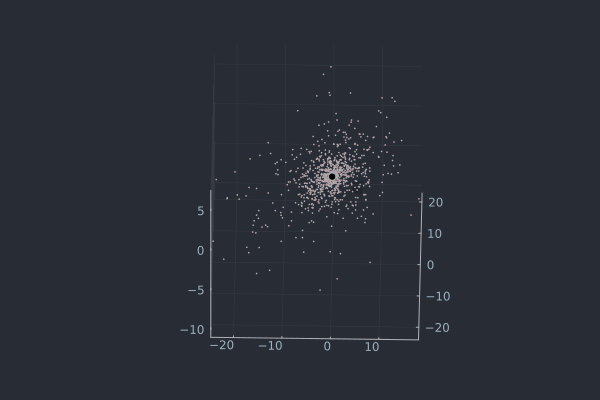

In [4]:

gif_galaxy(data,time,Target["NₛDisk"],Target["NₛBulge"])
#print_galaxy(data,time,0,200,40)


┌ Info: Saved animation to /tmp/jl_gZYVS9WjEv.gif
└ @ Plots /home/biel/.julia/packages/Plots/QZRtR/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_gZYVS9WjEv.gif")
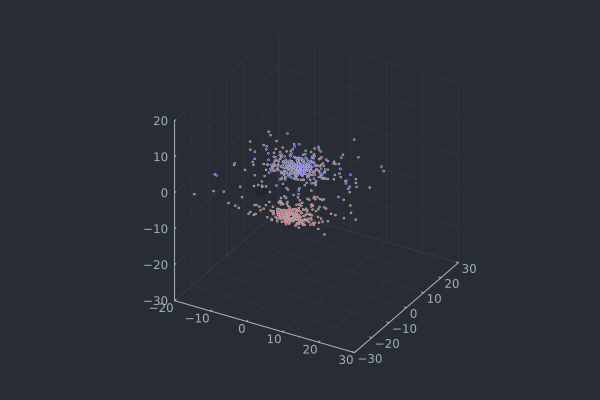

In [55]:
gif_two_galaxies(data,time,Target["NₛDisk"]+Target["NₛBulge"],Introoder["NₛDisk"]+Introoder["NₛBulge"],[-20,30],[-30,30],[-30,20])


In [5]:
Rminimum = Target["softening"] * Target["BulgeRadius"]
Rbulge = (-log.(rand(Target["NₛBulge"]))*Target["BulgeRadius"] .+Rminimum) #This (by inverse tansform sampling) gives us a negative exponential distribution on the masses. Basing myself on https://arxiv.org/pdf/1608.08350.pdf for this model
ϕbulge = 2π *rand(Target["NₛBulge"])
θbulge = π *rand(Target["NₛBulge"])
vecᵣbulge = Spherical2Cartesian.(ustrip.(u"m",Rbulge),ϕbulge,θbulge)
ustrip.(u"m/s",√(G *Target["mass"]/(norm(vecᵣbulge[1])*1u"kpc"))) *normalize(vecᵣbulge[1] × rand(3))
Rdisk = (-log.(rand(galaxy["NₛDisk"]))*galaxy["DiskRadius"] .+Rminimum)


UndefVarError: UndefVarError: galaxy not defined

In [56]:
time

200-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0